# Making a Timelapse From Uncabled Images

In this example, you will use OpenCV to timestamp images and combine them into an MP4 timelapse.

This example focuses on images collected by the camera located on the CE09OSSM MFN between April - June 2023.

In [1]:
!pip install fsspec
!pip install numpy
!pip install opencv-python

In [2]:
import cv2
from datetime import datetime
import fsspec
import os
import re
import requests
import warnings

## Helper Functions

The following functions are used to find files of interest, download them, and build a timelapse out of the downloaded files.

In [3]:
def find_uncabled_files(site: str, begin_datetime: datetime, end_datetime: datetime, verbose: bool = False) -> list:
    """
    Find recovered CAMDS files between two datetimes associated with a particular site. 
    This function does not care about deployment limits.
    
    :param site: An 8-character OOI designator for an uncabled site that has a CAMDS.
    :param begin_datetime: The beginning of the timespan of interest.
    :param end_datetime: The ending of the timespan of interest.
    :param verbose: If True, will notify the user if there are no files associated with a particular deployment.
    :return: A pythonic list of remote urls.    
    """
    remote = fsspec.filesystem('http')
    base_dir = f'https://rawdata.oceanobservatories.org/files/{site.upper()}/'
    dirs = remote.glob(base_dir + '*')
    depdirs = [d for d in dirs if 'R0' in d]
    foi = []
    for depdir in depdirs:
        files = remote.glob(depdir + 'cg_data/dcl37/camds/*.jpg')
        if len(files) == 0:
            files = remote.glob(depdir + 'cg_data/dcl37/camds/*.png')
        if len(files) == 0:
            if verbose is True:
                warnings.warn(f'No files found in {depdir}.')
            continue
        for file in files:
            filename = os.path.basename(file)
            filedt = datetime.strptime(re.findall('(\d{8}T\d{6})',filename)[0], '%Y%m%dT%H%M%S')
            if begin_datetime <= filedt <= end_datetime:
                foi.append(file)
    return foi


def download_files(urls: list, save_dir: os.path.abspath = os.path.join(os.getcwd(), 'files'), overwrite:bool = False) -> list:
    """
    Download files from remote urls.
    
    :param urls: A list of urls generated by find_uncabled_files.
    :param save_dir: A location to save files. By default it is the ooi-data-explorations/python/examples/camds directory.
    :param overwrite: If True, previously downloaded files will be overwritten.
    
    :return: A list of local files.
    """
    local_files = []  
    os.makedirs(save_dir, exist_ok=True)
    for url in urls:
        filename = os.path.basename(url)
        filepath = os.path.join(save_dir, filename)
        if os.path.exists(filepath) and overwrite is False:
            local_files.append(filepath)
            continue
        data = requests.get(url, stream = True).content
        with open(filepath,'wb') as writer:
            writer.write(data)
            local_files.append(filepath)
    return local_files


def open_image(filepath: os.path.abspath) -> object:
    """
    Open a local file as an opencv object.
    
    :param filepath: The local filepath of the image.
    :return: An opencv image object.
    """
    im = cv2.imread(filepath)
    return im


def resize(im: object, scale: float = 0.5) -> object:
    """
    Resize the image.
    
    :param im: An opencv image object.
    :param scale: The scale at which to resize.
    
    :return: The resized opencv image object.    
    """
    im = cv2.resize(im,(0,0), fx = scale, fy = scale)
    return im


def timestamp_image(im: object, dtstr, position: tuple = (50,100), font: int = cv2.FONT_HERSHEY_SIMPLEX, size:float = 1.5, color:tuple = (255,255,255), thickness:float or int = 2, alias: int = cv2.LINE_AA):
    """
    Timestamp an opencv image object.
    
    :param im: An opencv image object.
    :param dtstr: The timestamp string.
    :param position: A tuple dictating the position of the text.
    :param font: An integer indicating the font to use.
    :param size: The size of the text.
    :param color: The color of the text.
    :param thickness: The thickness of the text.    
    :param alias: Alias status of the text.
    
    :return: The opencv image object timestamped.
    """
    im = cv2.putText(im, dtstr, position, font, size, color, thickness, alias)
    return im


def build_timelapse(local_files: list, filename: os.path.abspath, fps: int = 30, fourcc: object = cv2.VideoWriter_fourcc(*'mp4v')) -> None:
    """
    Build a timelapse from local files.
    
    :param local_files: A list of local image files.
    :param filename: A filepath/filename to save the timelapse.
    :param fps: Number of frames per second.
    :param fourcc: Fourcc conditions for writing video. Default is .mp4v.    
    """
    init = open_image(local_files[0])
    height, width, _ = init.shape
    timelapse = cv2.VideoWriter(filename, fourcc, fps, (width, height))
    for file in local_files:
        _dtstr = re.findall('(\d{8}T\d{6})',file)[0]
        dt = datetime.strptime(_dtstr,'%Y%m%dT%H%M%S')
        dtstr = dt.strftime('%Y-%m-%dT%H:%M:%S') + 'Z'
        im = open_image(file)    
        im = timestamp_image(im, dtstr)
        timelapse.write(im)        
    timelapse.release()

## Find and Download Files

In [4]:
site = 'CE09OSSM'
begin_datetime = datetime(2023,6,1)
end_datetime = datetime(2023,6,30,23,59,59)

In [5]:
remote_files = find_uncabled_files(site, begin_datetime,end_datetime)

In [6]:
%%time
local_files = download_files(remote_files)

CPU times: user 1.13 ms, sys: 8.11 ms, total: 9.24 ms
Wall time: 108 ms


## View a file

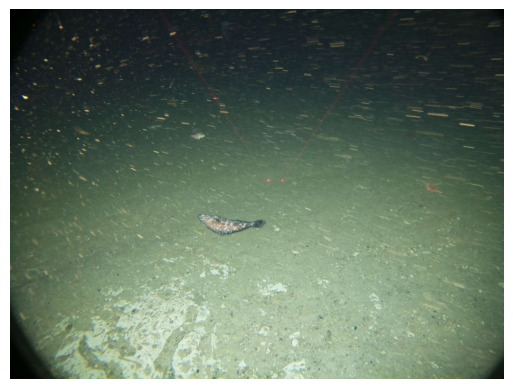

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(local_files[323])
plt.imshow(img)
plt.axis('off')  # Optional: removes axis labels and ticks
plt.show()

## Make A Timelapse
The timelapse will be stored as a video file in the same directory as this file. Download the file to view it.

In [8]:
%%time
filename = f'{site}.mp4'
build_timelapse(local_files, filename = os.path.join(os.getcwd(), filename), fps = 10)

CPU times: user 25.4 s, sys: 257 ms, total: 25.6 s
Wall time: 26.7 s
